In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import stats
import pickle

_ = np.random.seed(0)

In [6]:
def ode_system(y, t, beta, kappa, gamma, N):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - kappa * E
    dIdt = kappa * E - gamma * I
    dRdt = gamma * I
    return [dSdt, dEdt, dIdt, dRdt]

def simulate(parameters, ic, T):
    beta, kappa, gamma = parameters
    S0, E0, I0, R0 = ic

    N = S0 + E0 + I0 + R0
    y0=ic
    
    t = np.arange(T+1)
    ret = odeint(ode_system, y0, t, args=(beta, kappa, gamma, N))

    return ret[1:]

In [7]:
def sample_prior(n):
    return {
        'beta': np.random.uniform(0.2, 1.5, n),
        'kappa': np.random.uniform(0.1, 0.5, n),
        'gamma': np.random.uniform(0.05, 0.4, n),
    }

In [8]:
def simulator(sim_par, ic, T):
    beta = sim_par[0].item()
    kappa = sim_par[1].item()
    gamma = sim_par[2].item()
    
    sim=simulate(parameters=[beta, kappa, gamma],ic=ic,T=T)

    cases1 = kappa * sim[:,1]
    cases2 = sim[:,2]
    cases3 = gamma * sim[:,2]

    # cases1_obs = poisson_noise(np.maximum(cases1,1e-6))
    # cases2_obs = poisson_noise(np.maximum(cases2,1e-6))
    # cases3_obs = poisson_noise(np.maximum(cases3,1e-6))

    return sim, np.stack([cases1,cases2,cases3],axis=1)

In [9]:
# noise function
def poisson_noise(simulation):
    
    with_noise = np.random.poisson(np.maximum(simulation, 1e-6))

    return np.asarray(with_noise)


def nb_noise(simulation, r_param):
    sim_for_params = np.maximum(simulation, 1e-6) # Ensure mean is positive
    r_param_for_calc = np.maximum(r_param, 1e-6) # Ensure r_param is positive
    p_param = r_param_for_calc / (sim_for_params + r_param_for_calc)

    with_noise = stats.nbinom.rvs(n=r_param_for_calc, p=p_param)

    return np.asarray(with_noise)

In [10]:
n_samples = 10
priors = sample_prior(n_samples)
param_sets = [{k: priors[k][i] for k in priors} for i in range(n_samples)]

In [11]:
N=10000
E0 = 0
I0 = 10
R0 = 0
S0 = N - E0 - I0 - R0

duration=100

init_cond = [S0, E0, I0, R0]

In [12]:
simulation_dataset = []
for param in param_sets:
    sim_par = np.array([param['beta'], param['kappa'],  param['gamma'] ])
    sim_compartment, sim_output = simulator(sim_par, ic=init_cond, T=duration)
    simulation_dataset.append({'params': param, 
                               'compartment': sim_compartment,
                               'true': sim_output, 
                               'poisson':poisson_noise(sim_output),
                              'nb1':nb_noise(sim_output,100),
                              'nb2':nb_noise(sim_output,50),
                              'nb3':nb_noise(sim_output,10)})

In [10]:
with open("sim_dataset.pkl", "wb") as f:
    pickle.dump(simulation_dataset, f)

In [11]:
simulation_dataset[0]['params']

{'beta': np.float64(0.9134575551055222),
 'kappa': np.float64(0.4166900152330658),
 'gamma': np.float64(0.3925164197814674)}

In [14]:
len(simulation_dataset[0]['true'][:,0])

100

In [17]:
for i in range(10):
    print(simulation_dataset[i]['true'][0,0])

2.7035789028806043
2.7064003465460496
2.5935104693602984
3.0837826249768576
0.877604322656178
1.1704595916575447
0.7591718391562048
4.3145520595385145
4.779472869335597
2.3947897953059014


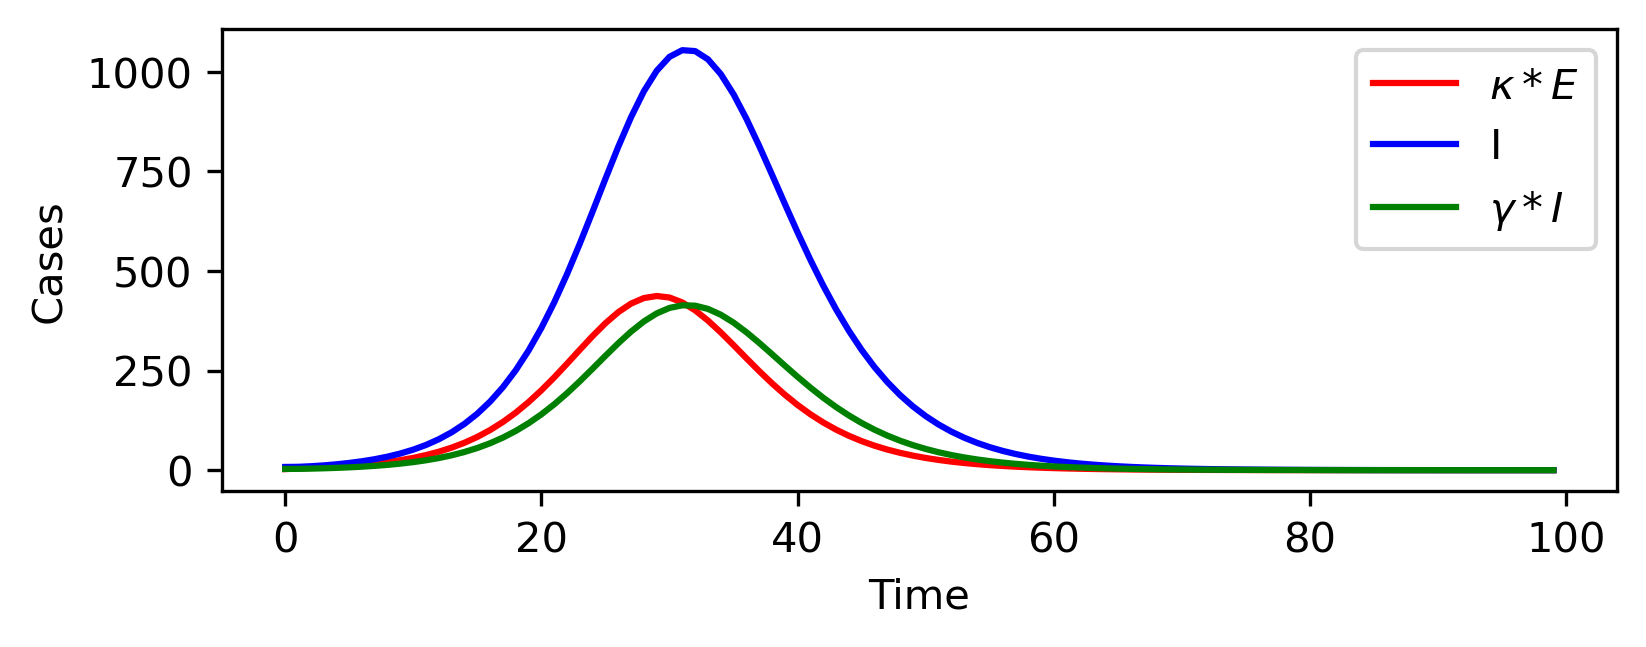

In [13]:
plt.subplots(1, 1, figsize=(6, 2),dpi=300)

plt.plot(np.arange(0,duration), simulation_dataset[0]['true'][:,0],  color="red", label=r"$\kappa * E$")
plt.plot(np.arange(0,duration), simulation_dataset[0]['true'][:,1],  color="blue", label="I")
plt.plot(np.arange(0,duration), simulation_dataset[0]['true'][:,2],  color="green", label=r"$\gamma * I$")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Cases")
plt.title("")
plt.show()

In [3]:
with open('./sim_dataset.pkl', 'rb') as f:
    simulation_dataset = pickle.load(f)

In [7]:
simulation_dataset[0]['params']

{'beta': np.float64(0.9134575551055222),
 'kappa': np.float64(0.4166900152330658),
 'gamma': np.float64(0.3925164197814674)}

In [9]:
params=[sim['params'] for sim in simulation_dataset]

In [13]:
pd.DataFrame(params).to_excel('true_params.xlsx',index=False)